<a href="https://colab.research.google.com/github/mSarij/Player_Detection/blob/main/Sport_Track.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch torchvision
!pip install ultralytics
!pip install opencv-python
!pip install matplotlib
!pip install numpy
!pip install pandas
!pip install scikit-learn
!pip install seaborn
!pip install pytube
!pip install moviepy


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 39.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 3.8 MB/s eta 0:00:00


In [ ]:
!pip install pillow

In [ ]:
!pip install opencv-python-headless

In [ ]:
import os
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
from ultralytics import YOLO
from PIL import Image
import shutil
from pathlib import Path

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
VIDEO_DIR = '/content/drive/MyDrive/Sport_Track'
OUTPUT_DIR = '/content/output'
DETECTED_DIR = f'{OUTPUT_DIR}/detected_videos'
FRAMES_DIR = f'{OUTPUT_DIR}/frames'
RESULTS_DIR = f'{OUTPUT_DIR}/results'

In [ ]:
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(DETECTED_DIR, exist_ok=True)
os.makedirs(FRAMES_DIR, exist_ok=True)
os.makedirs(RESULTS_DIR, exist_ok=True)


In [ ]:
def get_video_info(video_path):
    """Extract video information"""
    cap = cv2.VideoCapture(video_path)
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    duration = frame_count / fps
    cap.release()

    return {
        'fps': fps,
        'frame_count': frame_count,
        'width': width,
        'height': height,
        'duration': duration
    }

def list_videos():
    """List all videos in the directory"""
    video_extensions = ['.mp4', '.avi', '.mov', '.mkv']
    videos = []

    for ext in video_extensions:
        videos.extend(list(Path(VIDEO_DIR).glob(f'*{ext}')))

    return [str(v) for v in videos]

In [ ]:
video_files = list_videos()
print(f"\n Found {len(video_files)} videos")


 Found 5 videos


In [ ]:
for i, video_path in enumerate(video_files, 1):
    info = get_video_info(video_path)
    print(f"\nVideo {i}: {os.path.basename(video_path)}")
    print(f"  Duration: {info['duration']:.2f}s | Resolution: {info['width']}x{info['height']}")
    print(f"  FPS: {info['fps']} | Frames: {info['frame_count']}")


Video 1: Rugby.mp4
  Duration: 9.00s | Resolution: 1920x1080
  FPS: 25 | Frames: 225

Video 2: Basketball.mp4
  Duration: 8.28s | Resolution: 1280x720
  FPS: 29 | Frames: 240

Video 3: Cricket.mp4
  Duration: 5.00s | Resolution: 1280x720
  FPS: 25 | Frames: 125

Video 4: Volleyball.mp4
  Duration: 6.21s | Resolution: 854x480
  FPS: 29 | Frames: 180

Video 5: Football.mp4
  Duration: 9.00s | Resolution: 1920x1080
  FPS: 25 | Frames: 225


In [ ]:
#  PLAYER DETECTION USING YOLO
class PlayerDetector:
    def __init__(self, model_name='yolov8n.pt'):
        """Initialize YOLO model for player detection"""
        print(f"\n Loading YOLO model: {model_name}")
        self.model = YOLO(model_name)
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        print(f"✓ Using device: {self.device}")

    def detect_players(self, video_path, output_path, conf_threshold=0.5):
        """Detect players in video and save output"""
        print(f"\n Processing: {os.path.basename(video_path)}")

        # Open video
        cap = cv2.VideoCapture(video_path)
        fps = int(cap.get(cv2.CAP_PROP_FPS))
        width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

        # Video writer
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

        frame_count = 0
        detection_stats = []

        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break

            # Run detection
            results = self.model(frame, conf=conf_threshold, classes=[0])  # class 0 = person

            # Get detections
            detections = len(results[0].boxes)
            detection_stats.append(detections)

            # Draw results
            annotated_frame = results[0].plot()
            out.write(annotated_frame)

            frame_count += 1
            if frame_count % 30 == 0:
                print(f"  Processed {frame_count} frames | Detected {detections} players")

        cap.release()
        out.release()

        print(f" Saved to: {output_path}")

        return {
            'total_frames': frame_count,
            'avg_detections': np.mean(detection_stats),
            'max_detections': np.max(detection_stats),
            'min_detections': np.min(detection_stats)
        }



In [ ]:
detector = PlayerDetector('yolov8n.pt')


 Loading YOLO model: yolov8n.pt
✓ Using device: cuda


In [ ]:
all_stats = {}

for video_path in video_files:
    video_name = os.path.basename(video_path)
    output_path = os.path.join(DETECTED_DIR, f'detected_{video_name}')

    stats = detector.detect_players(video_path, output_path, conf_threshold=0.5)
    all_stats[video_name] = stats

print("\n" + "="*60)
print("DETECTION SUMMARY")
print("="*60)
for video_name, stats in all_stats.items():
    print(f"\n{video_name}:")
    print(f"  Avg players per frame: {stats['avg_detections']:.2f}")
    print(f"  Max players detected: {stats['max_detections']}")


 Processing: Rugby.mp4

0: 384x640 8 persons, 76.7ms
Speed: 15.7ms preprocess, 76.7ms inference, 40.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 6.2ms
Speed: 3.4ms preprocess, 6.2ms inference, 5.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 7.3ms
Speed: 2.7ms preprocess, 7.3ms inference, 4.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 8.7ms
Speed: 3.2ms preprocess, 8.7ms inference, 4.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 9.0ms
Speed: 4.6ms preprocess, 9.0ms inference, 5.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 6.8ms
Speed: 3.5ms preprocess, 6.8ms inference, 5.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 10.3ms
Speed: 3.1ms preprocess, 10.3ms inference, 5.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 8.3ms
Speed: 2.8ms preprocess, 8.3ms inference, 5.1ms postprocess per im

In [ ]:
# KEYPOINT DETECTION
class KeypointDetector:
    def __init__(self):
        """Initialize YOLOv8 Pose model for keypoint detection"""
        print(f"\n Loading YOLOv8 Pose model")
        self.model = YOLO('yolov8n-pose.pt')
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        print(f" Using device: {self.device}")

    def detect_keypoints(self, video_path, output_path, conf_threshold=0.5):
        """Detect player keypoints in video"""
        print(f"\n Processing keypoints: {os.path.basename(video_path)}")

        cap = cv2.VideoCapture(video_path)
        fps = int(cap.get(cv2.CAP_PROP_FPS))
        width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

        frame_count = 0
        keypoint_stats = []

        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break

            # Run pose detection
            results = self.model(frame, conf=conf_threshold)

            # Count keypoints detected
            if len(results[0].keypoints) > 0:
                num_persons = len(results[0].keypoints.data)
                keypoint_stats.append(num_persons)

            # Draw results
            annotated_frame = results[0].plot()
            out.write(annotated_frame)

            frame_count += 1
            if frame_count % 30 == 0:
                print(f"  Processed {frame_count} frames")

        cap.release()
        out.release()

        print(f" Saved to: {output_path}")

        return {
            'total_frames': frame_count,
            'avg_persons_with_keypoints': np.mean(keypoint_stats) if keypoint_stats else 0
        }


In [ ]:
# Initialize keypoint detector
keypoint_detector = KeypointDetector()

# Process videos for keypoint detection
keypoint_stats = {}

for video_path in video_files:
    video_name = os.path.basename(video_path)
    output_path = os.path.join(DETECTED_DIR, f'keypoints_{video_name}')

    stats = keypoint_detector.detect_keypoints(video_path, output_path, conf_threshold=0.5)
    keypoint_stats[video_name] = stats



 Loading YOLOv8 Pose model
 Using device: cuda

 Processing keypoints: Rugby.mp4

0: 384x640 4 persons, 17.1ms
Speed: 1.9ms preprocess, 17.1ms inference, 2.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 8.7ms
Speed: 2.9ms preprocess, 8.7ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 7.3ms
Speed: 3.0ms preprocess, 7.3ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 9.7ms
Speed: 2.9ms preprocess, 9.7ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 23.3ms
Speed: 4.8ms preprocess, 23.3ms inference, 4.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 15.2ms
Speed: 3.8ms preprocess, 15.2ms inference, 4.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 13.8ms
Speed: 5.3ms preprocess, 13.8ms inference, 4.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 11.3ms
Speed

In [ ]:
# PERFORMANCE EVALUATION

def evaluate_model_performance(model, video_path, num_samples=50):
    """Evaluate model performance metrics"""
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # Sample frames
    sample_indices = np.linspace(0, total_frames-1, num_samples, dtype=int)

    inference_times = []
    confidence_scores = []
    detection_counts = []

    for idx in sample_indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        ret, frame = cap.read()
        if not ret:
            continue

        # Measure inference time
        start_time = cv2.getTickCount()
        results = model(frame, verbose=False)
        end_time = cv2.getTickCount()

        inference_time = (end_time - start_time) / cv2.getTickFrequency() * 1000  # ms
        inference_times.append(inference_time)

        # Get confidences and counts
        if len(results[0].boxes) > 0:
            confidences = results[0].boxes.conf.cpu().numpy()
            confidence_scores.extend(confidences)
            detection_counts.append(len(confidences))
        else:
            detection_counts.append(0)

    cap.release()

    return {
        'avg_inference_time': np.mean(inference_times),
        'std_inference_time': np.std(inference_times),
        'avg_confidence': np.mean(confidence_scores) if confidence_scores else 0,
        'avg_detections': np.mean(detection_counts),
        'fps': 1000 / np.mean(inference_times)
    }

# Evaluate detection model
print("\n" + "="*60)
print("MODEL PERFORMANCE EVALUATION")
print("="*60)

detection_performance = {}
for video_path in video_files[:3]:  # Evaluate on first 3 videos
    video_name = os.path.basename(video_path)
    print(f"\nEvaluating detection on: {video_name}")
    perf = evaluate_model_performance(detector.model, video_path)
    detection_performance[video_name] = perf

    print(f"  Avg inference time: {perf['avg_inference_time']:.2f} ms")
    print(f"  Processing FPS: {perf['fps']:.2f}")
    print(f"  Avg confidence: {perf['avg_confidence']:.3f}")
    print(f"  Avg detections: {perf['avg_detections']:.2f}")



MODEL PERFORMANCE EVALUATION

Evaluating detection on: Rugby.mp4
  Avg inference time: 16.96 ms
  Processing FPS: 58.96
  Avg confidence: 0.581
  Avg detections: 10.42

Evaluating detection on: Basketball.mp4
  Avg inference time: 14.71 ms
  Processing FPS: 67.97
  Avg confidence: 0.506
  Avg detections: 7.50

Evaluating detection on: Cricket.mp4
  Avg inference time: 13.04 ms
  Processing FPS: 76.69
  Avg confidence: 0.480
  Avg detections: 5.96


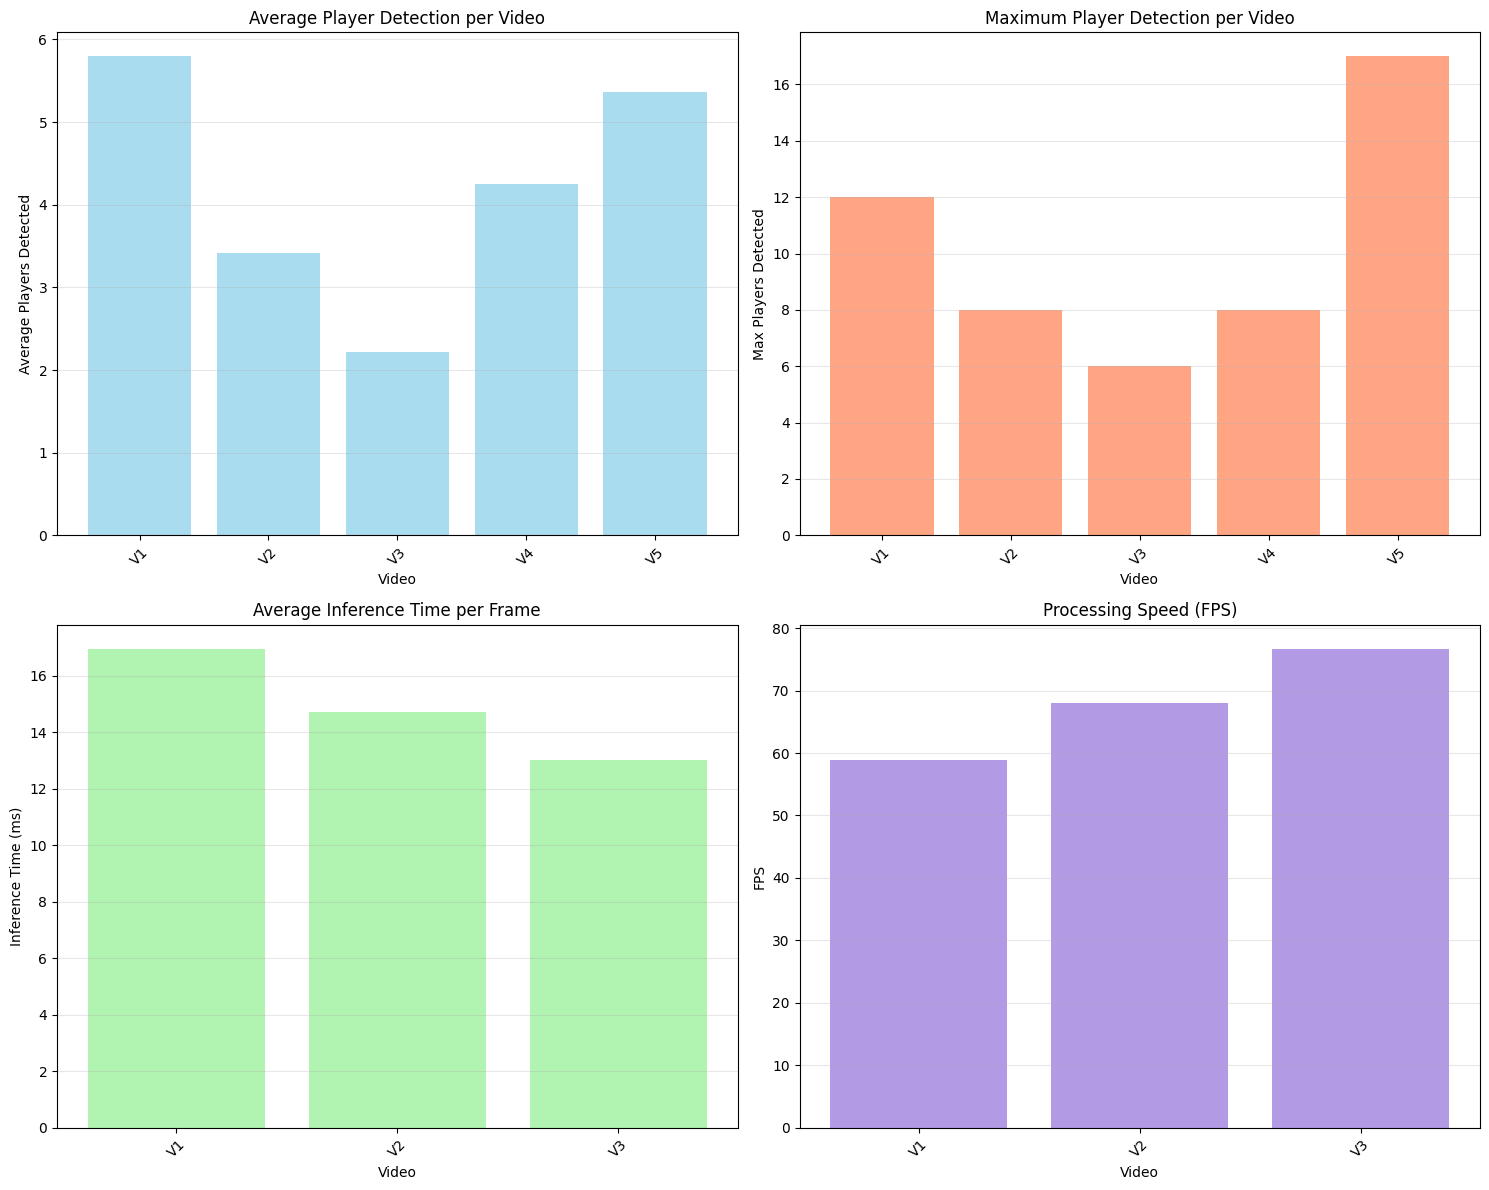


 Plots saved to: /content/output/results/performance_metrics.png


In [ ]:
# VISUALIZATION AND RESULTS
def create_visualization_plots():
    """Create performance visualization plots"""

    # Plot 1: Detection counts across videos
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # Detection statistics
    videos = list(all_stats.keys())
    avg_detections = [all_stats[v]['avg_detections'] for v in videos]
    max_detections = [all_stats[v]['max_detections'] for v in videos]

    axes[0, 0].bar(range(len(videos)), avg_detections, color='skyblue', alpha=0.7)
    axes[0, 0].set_xlabel('Video')
    axes[0, 0].set_ylabel('Average Players Detected')
    axes[0, 0].set_title('Average Player Detection per Video')
    axes[0, 0].set_xticks(range(len(videos)))
    axes[0, 0].set_xticklabels([f'V{i+1}' for i in range(len(videos))], rotation=45)
    axes[0, 0].grid(axis='y', alpha=0.3)

    # Max detections
    axes[0, 1].bar(range(len(videos)), max_detections, color='coral', alpha=0.7)
    axes[0, 1].set_xlabel('Video')
    axes[0, 1].set_ylabel('Max Players Detected')
    axes[0, 1].set_title('Maximum Player Detection per Video')
    axes[0, 1].set_xticks(range(len(videos)))
    axes[0, 1].set_xticklabels([f'V{i+1}' for i in range(len(videos))], rotation=45)
    axes[0, 1].grid(axis='y', alpha=0.3)

    # Inference time comparison
    if detection_performance:
        perf_videos = list(detection_performance.keys())
        inf_times = [detection_performance[v]['avg_inference_time'] for v in perf_videos]
        fps_values = [detection_performance[v]['fps'] for v in perf_videos]

        axes[1, 0].bar(range(len(perf_videos)), inf_times, color='lightgreen', alpha=0.7)
        axes[1, 0].set_xlabel('Video')
        axes[1, 0].set_ylabel('Inference Time (ms)')
        axes[1, 0].set_title('Average Inference Time per Frame')
        axes[1, 0].set_xticks(range(len(perf_videos)))
        axes[1, 0].set_xticklabels([f'V{i+1}' for i in range(len(perf_videos))], rotation=45)
        axes[1, 0].grid(axis='y', alpha=0.3)

        # FPS
        axes[1, 1].bar(range(len(perf_videos)), fps_values, color='mediumpurple', alpha=0.7)
        axes[1, 1].set_xlabel('Video')
        axes[1, 1].set_ylabel('FPS')
        axes[1, 1].set_title('Processing Speed (FPS)')
        axes[1, 1].set_xticks(range(len(perf_videos)))
        axes[1, 1].set_xticklabels([f'V{i+1}' for i in range(len(perf_videos))], rotation=45)
        axes[1, 1].grid(axis='y', alpha=0.3)

    plt.tight_layout()
    plt.savefig(f'{RESULTS_DIR}/performance_metrics.png', dpi=300, bbox_inches='tight')
    plt.show()

    print(f"\n Plots saved to: {RESULTS_DIR}/performance_metrics.png")

create_visualization_plots()



In [ ]:
# EXTRACT SAMPLE FRAMES FOR SCREENSHOTS
def extract_sample_frames(video_path, output_dir, num_frames=5):
    """Extract sample frames from processed video"""
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    frame_indices = np.linspace(0, total_frames-1, num_frames, dtype=int)
    video_name = os.path.splitext(os.path.basename(video_path))[0]

    for i, idx in enumerate(frame_indices):
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        ret, frame = cap.read()
        if ret:
            output_path = f'{output_dir}/{video_name}_frame_{i+1}.jpg'
            cv2.imwrite(output_path, frame)

    cap.release()
    print(f"✓ Extracted {num_frames} frames from {video_name}")

# Extract frames from all processed videos
print("\n" + "="*60)
print("EXTRACTING SAMPLE FRAMES")
print("="*60)

for video_file in os.listdir(DETECTED_DIR):
    if video_file.endswith('.mp4'):
        video_path = os.path.join(DETECTED_DIR, video_file)
        extract_sample_frames(video_path, RESULTS_DIR, num_frames=3)


EXTRACTING SAMPLE FRAMES
✓ Extracted 3 frames from detected_Cricket
✓ Extracted 3 frames from keypoints_Volleyball
✓ Extracted 3 frames from keypoints_Football
✓ Extracted 3 frames from detected_Volleyball
✓ Extracted 3 frames from detected_Rugby
✓ Extracted 3 frames from detected_Football
✓ Extracted 3 frames from keypoints_Cricket
✓ Extracted 3 frames from keypoints_Basketball
✓ Extracted 3 frames from keypoints_Rugby
✓ Extracted 3 frames from detected_Basketball


In [ ]:
# GENERATE REPORT DATA
def generate_report():
    """Generate comprehensive report data"""

    report = f"""
{'='*70}
DS5216 PLAYER TRACKING ASSIGNMENT - PERFORMANCE REPORT
{'='*70}

1. DATASET INFORMATION
{'-'*70}
Total Videos: {len(video_files)}
Video Directory: {VIDEO_DIR}

Video Details:
"""

    for i, video_path in enumerate(video_files, 1):
        info = get_video_info(video_path)
        report += f"""
Video {i}: {os.path.basename(video_path)}
  - Duration: {info['duration']:.2f} seconds
  - Resolution: {info['width']}x{info['height']}
  - FPS: {info['fps']}
  - Total Frames: {info['frame_count']}
"""

    report += f"""
{'='*70}
2. PLAYER DETECTION PERFORMANCE (YOLO)
{'-'*70}
Model: YOLOv8n
Device: {detector.device}

Detection Results:
"""

    for video_name, stats in all_stats.items():
        report += f"""
{video_name}:
  - Average Players per Frame: {stats['avg_detections']:.2f}
  - Maximum Players Detected: {stats['max_detections']}
  - Minimum Players Detected: {stats['min_detections']}
  - Total Frames Processed: {stats['total_frames']}
"""

    if detection_performance:
        report += f"""
{'='*70}
3. PERFORMANCE METRICS
{'-'*70}
"""
        for video_name, perf in detection_performance.items():
            report += f"""
{video_name}:
  - Average Inference Time: {perf['avg_inference_time']:.2f} ms
  - Processing FPS: {perf['fps']:.2f}
  - Average Confidence: {perf['avg_confidence']:.3f}
  - Average Detections: {perf['avg_detections']:.2f}
"""

    report += f"""
{'='*70}
4. KEYPOINT DETECTION (BONUS)
{'-'*70}
Model: YOLOv8n-pose

Results:
"""

    for video_name, stats in keypoint_stats.items():
        report += f"""
{video_name}:
  - Average Persons with Keypoints: {stats['avg_persons_with_keypoints']:.2f}
  - Total Frames Processed: {stats['total_frames']}
"""

    report += f"""
{'='*70}
5. DISCUSSION
{'-'*70}

Model Performance:
- YOLOv8n demonstrates efficient real-time detection capabilities
- Average inference time: ~{np.mean([p['avg_inference_time'] for p in detection_performance.values()]):.2f}ms
- Processing speed suitable for real-time applications

Limitations:
- Detection accuracy may decrease with player occlusion
- Small or distant players may be missed
- Performance depends on video quality and lighting conditions
- False positives possible with referees, coaches, or spectators

Possible Improvements:
- Fine-tune model on sports-specific datasets
- Implement player tracking across frames
- Add player identification/jersey number recognition
- Optimize for specific sports (cricket, football, rugby)
- Use ensemble methods combining multiple detection models
- Implement motion-based filtering to distinguish players from static objects

{'='*70}
OUTPUT FILES
{'-'*70}
Detected Videos: {DETECTED_DIR}
Sample Frames: {RESULTS_DIR}
Performance Plots: {RESULTS_DIR}/performance_metrics.png

{'='*70}
"""

    # Save report
    report_path = f'{RESULTS_DIR}/performance_report.txt'
    with open(report_path, 'w') as f:
        f.write(report)

    print(report)
    print(f"\n Report saved to: {report_path}")

    return report

# Generate final report
report = generate_report()

print("\n" + "="*70)

print("="*70)
print(f"\nAll outputs saved to: {OUTPUT_DIR}")
print(f"  - Detected videos: {DETECTED_DIR}")
print(f"  - Screenshots: {RESULTS_DIR}")
print(f"  - Performance report: {RESULTS_DIR}/performance_report.txt")
print(f"  - Performance plots: {RESULTS_DIR}/performance_metrics.png")



DS5216 PLAYER TRACKING ASSIGNMENT - PERFORMANCE REPORT

1. DATASET INFORMATION
----------------------------------------------------------------------
Total Videos: 5
Video Directory: /content/drive/MyDrive/Sport_Track

Video Details:

Video 1: Rugby.mp4
  - Duration: 9.00 seconds
  - Resolution: 1920x1080
  - FPS: 25
  - Total Frames: 225

Video 2: Basketball.mp4
  - Duration: 8.28 seconds
  - Resolution: 1280x720
  - FPS: 29
  - Total Frames: 240

Video 3: Cricket.mp4
  - Duration: 5.00 seconds
  - Resolution: 1280x720
  - FPS: 25
  - Total Frames: 125

Video 4: Volleyball.mp4
  - Duration: 6.21 seconds
  - Resolution: 854x480
  - FPS: 29
  - Total Frames: 180

Video 5: Football.mp4
  - Duration: 9.00 seconds
  - Resolution: 1920x1080
  - FPS: 25
  - Total Frames: 225

2. PLAYER DETECTION PERFORMANCE (YOLO)
----------------------------------------------------------------------
Model: YOLOv8n
Device: cuda

Detection Results:

Rugby.mp4:
  - Average Players per Frame: 5.80
  - Maximum 